In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective, SparseObjective

import matplotlib.pyplot as plt
%matplotlib inline

#import numpy as np

import autograd
import autograd.numpy as np

import copy
from scipy import optimize

import os
import json

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

analysis_name = 'simulated_data_small'
#analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')
json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']
#vp_base = json_dat['vp_base']

print(stan_dat.keys())
K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
#N = NObs / NG
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

# Define a class to contain prior parameters.
prior_par = logit_glmm.get_default_prior_params(K)
prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

prior_par['beta_prior_info'].set(np.array(stan_dat['beta_prior_info']))

prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
prior_par['mu_prior_info'].set(stan_dat['mu_prior_info'][0])

prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])

# An index set to make sure jacobians match the order expected by R.
prior_par_indices = copy.deepcopy(prior_par)
prior_par_indices.set_name('Prior Indices')
prior_par_indices.set_vector(np.array(range(prior_par_indices.vector_size())))

free_par_vec = glmm_par.get_free()
init_par_vec = copy.deepcopy(free_par_vec)

print(np.mean(y_vec))

dict_keys(['y_group', 'x', 'tau_prior_alpha', 'mu_prior_mean', 'mu_prior_info', 'beta_prior_info', 'y', 'N', 'beta_prior_mean', 'tau_prior_beta', 'NG', 'K'])
0.324


In [3]:
# Define moment parameters
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
get_moment_jacobian = autograd.jacobian(moment_wrapper.get_moment_vector)
moment_jac = get_moment_jacobian(init_par_vec)


model = logit_glmm.LogisticGLMM(glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=10)
model.get_e_log_prior()
model.get_log_lik()
model.get_entropy()

objective = Objective(model.glmm_par, model.get_kl)
objective.fun_free(free_par_vec)

# # PriorHess evaluates the second order derivative d2 EPrior / dpar dprior_par
def get_e_log_prior(prior_vec, free_par):
    model.glmm_par.set_free(free_par)
    model.prior_par.set_vector(prior_vec)
    return model.get_e_log_prior()

get_prior_model_grad = autograd.grad(get_e_log_prior, argnum=0)
get_prior_hess = autograd.jacobian(get_prior_model_grad, argnum=1)

import timeit

time_num = 10

num_draws = 3
model.set_gh_points(num_draws)
print('num_draws = ', num_draws)
print('\tFunction time:',
      timeit.timeit(lambda: objective.fun_free(free_par_vec), number=time_num) / time_num)

print('\tGrad time:', 
      timeit.timeit(lambda: objective.fun_free_grad(free_par_vec), number=time_num) / time_num)

print('\tHessian vector product time:',
      timeit.timeit(lambda: objective.fun_free_hvp(free_par_vec, free_par_vec + 1), number=time_num) / time_num)

prior_vec = model.prior_par.get_vector()
prior_hess_time = time.time()
get_prior_hess(prior_vec, init_par_vec)
prior_hess_time = time.time() - prior_hess_time
print('\tPrior hess time: ', prior_hess_time)


num_draws =  3
	Function time: 0.0007016121991910041
	Grad time: 0.006159485597163439
	Hessian vector product time: 0.012944937398424372
	Prior hess time:  0.06346654891967773


In [4]:
glmm_par.set_free(np.random.random(glmm_par.free_size()))
glmm_indices = copy.deepcopy(glmm_par)
glmm_indices.set_vector(np.arange(0, glmm_indices.vector_size()))

# Since we never use the free version of the observation parameters, we don't need to
# set the minimum allowable values.
def get_group_parameters(K):
    group_par = vb.ModelParamsDict('Single group GLMM parameters')
    group_par.push_param(vb.UVNParam('mu'))
    group_par.push_param(vb.GammaParam('tau'))
    group_par.push_param(vb.UVNParamVector('beta', K))
    group_par.push_param(vb.UVNParamVector('u', 1))
    return group_par

# Since we never use the free version of the global parameters, we don't need to
# set the minimum allowable values.
def get_global_parameters(K):
    global_par = vb.ModelParamsDict('Global GLMM parameters')
    global_par.push_param(vb.UVNParam('mu'))
    global_par.push_param(vb.GammaParam('tau'))
    global_par.push_param(vb.UVNParamVector('beta', K))
    return global_par


group_par = get_group_parameters(K)
global_par = get_global_parameters(K)



In [51]:
import VariationalBayes.ExponentialFamilies as ef


def get_global_entropy_args(info_mu, info_beta, tau_shape, tau_rate):
    return \
        ef.univariate_normal_entropy(info_mu) + \
        ef.multivariate_normal_entropy(info_beta) + \
        ef.gamma_entropy(tau_shape, tau_rate)

def get_data_log_lik(e_beta, var_beta, e_u, var_u,
                     x_mat, y_vec, y_g_vec, gh_x, gh_w):
    # Log likelihood from data.
    z_mean = e_u[y_g_vec] + np.matmul(x_mat, e_beta)
    z_sd = np.sqrt(
        var_u[y_g_vec] + np.einsum('nk,k,nk->n',
                          x_mat, var_beta, x_mat))
    return \
        np.sum(y_vec * z_mean) - \
        logit_glmm.get_e_logistic_term_guass_hermite(
            z_mean, z_sd, gh_x, gh_w, aggregate_all=True)

        
def get_re_log_lik(e_mu, var_mu, e_tau, e_log_tau, e_u, var_u):
    return -0.5 * e_tau * np.sum(
        ((e_mu - e_u) ** 2) + var_mu + var_u) + 0.5 * e_log_tau * len(e_u)



In [52]:

def set_group_parameters(glmm_par, group_par, group):
    group_par['beta'].set_vector(glmm_par['beta'].get_vector())
    group_par['mu'].set_vector(glmm_par['mu'].get_vector())
    group_par['tau'].set_vector(glmm_par['tau'].get_vector())

    group_par['u'].mean.set(glmm_par['u'].mean.get()[group])
    group_par['u'].info.set(glmm_par['u'].info.get()[group])

    
def set_global_parameters(glmm_par, group_par):
    global_par['beta'].set_vector(glmm_par['beta'].get_vector())
    global_par['mu'].set_vector(glmm_par['mu'].get_vector())
    global_par['tau'].set_vector(glmm_par['tau'].get_vector())


class SparseModelObjective(logit_glmm.LogisticGLMM):
    def __init__(self, glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points):
        super().__init__(glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points)

        self.glmm_indices = copy.deepcopy(self.glmm_par)
        self.glmm_indices.set_vector(np.arange(0, self.glmm_indices.vector_size()))

        # Parameters for a single observation.
        K = glmm_par['beta'].size()
        self.group_par = get_group_parameters(K)
        self.group_indices = get_group_parameters(K)
        self.group_indices.set_vector(np.arange(0, self.group_indices.vector_size()))
        
        self.group_rows = [ self.y_g_vec == g \
                            for g in range(np.max(self.y_g_vec) + 1)]
        
        self.global_par = get_global_parameters(K)
        self.global_indices = get_global_parameters(K)
        self.global_indices.set_vector(np.arange(0, self.global_indices.vector_size()))

    # Set the group parameters from the global parameters and
    # return a vector of the indices.
    def set_group_parameters(self, group):
        set_group_parameters(self.glmm_par, self.group_par, group)
        set_group_parameters(self.glmm_indices, self.group_indices, group)  
        return self.group_par.get_vector(), self.group_indices.get_vector()

    def set_global_parameters(self, unused_group=-1):
        set_global_parameters(self.glmm_par, self.global_par)
        set_global_parameters(self.glmm_indices, self.global_indices)  
        return self.global_par.get_vector(), self.global_indices.get_vector()

    # Likelihood functions:        
    def get_group_elbo(self, group):
        e_beta = self.group_par['beta'].e()
        var_beta = self.group_par['beta'].var()
        e_u = np.array([self.group_par['u'].e()])
        var_u = np.array([self.group_par['u'].var()])
        info_u = np.array([self.group_par['u'].info.get()])
        e_tau = self.group_par['tau'].e()
        e_log_tau = self.group_par['tau'].e_log()
        e_mu = self.group_par['mu'].e()
        var_mu = self.group_par['mu'].var()
        
        assert(len(e_u) == 1)
        assert(len(var_u) == 1)
        assert(len(info_u) == 1)
        
        return \
            get_data_log_lik(
                e_beta=e_beta,
                var_beta=var_beta,
                e_u=e_u,
                var_u=var_u,
                y_g_vec=[0],
                x_mat=self.x_mat[self.group_rows[group], :],
                y_vec=self.y_vec[self.group_rows[group]],
                gh_x=self.gh_x,
                gh_w=self.gh_w) + \
            get_re_log_lik(
                e_mu=e_mu,
                var_mu=var_mu,
                e_tau=e_tau,
                e_log_tau=e_log_tau,
                e_u=np.array([e_u]),
                var_u=np.array([var_u])) + \
            ef.univariate_normal_entropy(info_u)

    def get_global_elbo(self):
        e_beta = self.global_par['beta'].mean.get()
        info_beta = np.diag(self.global_par['beta'].info.get())
        cov_beta = np.diag(1. / self.global_par['beta'].info.get())
        
        e_mu = self.global_par['mu'].mean.get()
        info_mu = self.global_par['mu'].info.get()
        var_mu = 1 / info_mu
        
        tau_shape = self.global_par['tau'].shape.get()
        tau_rate = self.global_par['tau'].rate.get()
        e_tau = self.global_par['tau'].e()
        e_log_tau = self.global_par['tau'].e_log()
        
        e_log_p_beta = ef.mvn_prior(
            prior_mean=self.prior_par['beta_prior_mean'].get(),
            prior_info=self.prior_par['beta_prior_info'].get(),
            e_obs=e_beta, cov_obs=cov_beta)

        e_log_p_mu = ef.uvn_prior(
            prior_mean=self.prior_par['mu_prior_mean'].get(),
            prior_info=self.prior_par['mu_prior_info'].get(),
            e_obs=e_mu, var_obs=var_mu)

        e_log_p_tau = ef.gamma_prior(
            prior_shape=self.prior_par['tau_prior_alpha'].get(),
            prior_rate=self.prior_par['tau_prior_beta'].get(),
            e_obs=e_tau, e_log_obs=e_log_tau)

        return \
            ef.univariate_normal_entropy(info_mu) + \
            ef.multivariate_normal_entropy(info_beta) + \
            ef.gamma_entropy(tau_shape, tau_rate) + \
            e_log_p_beta + e_log_p_mu + e_log_p_tau
    
    def get_group_elbo_from_vec(self, group_par_vec, group):
        self.group_par.set_vector(group_par_vec)
        return self.get_group_elbo(group)
    
    def get_global_elbo_from_vec(self, global_par_vec, group):
        self.global_par.set_vector(global_par_vec)
        return self.get_global_elbo()



sparse_model = SparseModelObjective(glmm_par, prior_par, x_mat, y_vec, y_g_vec, 4)

sparse_model.set_group_parameters(1)
sparse_model.get_group_elbo(1)

sparse_model.set_global_parameters()
sparse_model.get_global_elbo()






1   1


5.104199869424968

In [53]:

objective = Objective(sparse_model.glmm_par, sparse_model.get_elbo)
full_elbo = objective.fun_vector(sparse_model.glmm_par.get_vector())

sparse_model.set_global_parameters()
sparse_elbo = sparse_model.get_global_elbo()
for g in range(NG):
    group_vec, group_inds = sparse_model.set_group_parameters(g)
    sparse_elbo += sparse_model.get_group_elbo_from_vec(group_vec, g)

print(sparse_elbo)
print(full_elbo)

1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
[-769.25021042]
-770.6542278654944


In [27]:
print('Gettin\' that ol\' Hessian:')

full_hess_time = time.time()
full_hess = objective.fun_vector_hessian(sparse_model.glmm_par.get_vector())
full_hess_time = time.time() - full_hess_time

print('Full Hessian time: ', full_hess_time)



Gettin' that ol' Hessian:
Full Hessian time:  2.4029366970062256


In [29]:

from scipy.sparse import csr_matrix

def get_sparse_hessian(
    set_parameters_fun, get_group_hessian, group_range, full_hess_dim, print_every=20):

    hess_vals = [] # These will be the entries of the Hessian
    hess_rows = [] # These will be the z indices
    hess_cols = [] # These will be the data indices

    group_vector, full_indices = set_parameters_fun(0)  
    group_hess_dim = len(group_vector)

    for group in group_range:
        if group % print_every == 0:
            print('Group {} of {}'.format(group, group_range.stop - 1))
        group_vector, full_indices = set_parameters_fun(group)  
        row_hess_val = np.squeeze(get_group_hessian(group_vector, group))

        for row in range(group_hess_dim):
            for col in range(group_hess_dim):
                if row_hess_val[row, col] != 0:
                    hess_vals.append(row_hess_val[row, col])
                    hess_rows.append(int(full_indices[row]))
                    hess_cols.append(int(full_indices[col]))

    print('Done.')
    return csr_matrix((hess_vals, (hess_rows, hess_cols)),
                      (full_hess_dim, full_hess_dim))


get_group_hessian = autograd.hessian(sparse_model.get_group_elbo_from_vec)
get_global_hessian = autograd.hessian(sparse_model.get_global_elbo_from_vec)

sparse_hess_time = time.time()

print('Global hessian:')
sparse_global_hess = get_sparse_hessian(
    set_parameters_fun=sparse_model.set_global_parameters,
    get_group_hessian=get_global_hessian,
    group_range=range(1),
    full_hess_dim = sparse_model.glmm_par.vector_size(),    
    print_every=1)

print('Local hessian:')
sparse_group_hess = get_sparse_hessian(
    set_parameters_fun=sparse_model.set_group_parameters,
    get_group_hessian=get_group_hessian,
    group_range=range(NG),
    full_hess_dim = sparse_model.glmm_par.vector_size(),
    print_every=10)

sparse_hess_time = time.time() - sparse_hess_time



Global hessian:
Group 0 of 0
Done.
Local hessian:
Group 0 of 99
Group 10 of 99
Group 20 of 99
Group 30 of 99
Group 40 of 99
Group 50 of 99
Group 60 of 99
Group 70 of 99
Group 80 of 99
Group 90 of 99
Done.


In [30]:
sparse_hess = sparse_global_hess + sparse_global_hess

print('Sparse Hessian time: ', sparse_hess_time)
print('Sparse Hessian time per group: ', sparse_hess_time  / float(NG))

print('Full Hessian time: ', full_hess_time)
print('Sparse Hessian time: ', sparse_hess_time)

print('Max difference (should be zero):', np.max(np.abs(full_hess - sparse_hess.todense())))
print('Stdev (so you know it\'s not all zeros):', np.std(full_hess[:]))


Sparse Hessian time:  8.975576639175415
Sparse Hessian time per group:  0.08975576639175414
Full Hessian time:  2.4029366970062256
Sparse Hessian time:  8.975576639175415
Max difference (should be zero): 91.2399229823
Stdev (so you know it's not all zeros): 1.27188416711


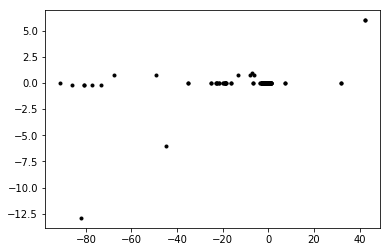

In [41]:
# full_hess[60:80, 60:80]
plt.plot(full_hess.flatten(), np.asarray(sparse_hess.todense()).flatten(), 'k.')